# 3.3 Construct the Data

In [1]:
import pyspark
from pyspark.sql.functions import col, count, isnan, when
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PySpark in Jupyter") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 11:51:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 11:51:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/23 11:51:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
df = spark.read.csv('Dataset/df_new_3.csv', header=True, inferSchema=True)

In [3]:
from pyspark.sql.functions import when

# Define conditions and apply them using when
df_grouped = df.withColumn("Education_Group", 
                           when((col("Education_Level") == "Primary School") | 
                                (col("Education_Level") == "Secondary School"), "Low Ed")
                           .otherwise("High Ed"))

# Show the result
df_grouped.select("Education_Level", "Education_Group").show()


+----------------+---------------+
| Education_Level|Education_Group|
+----------------+---------------+
|  Primary School|         Low Ed|
|  Primary School|         Low Ed|
|  Primary School|         Low Ed|
|  Primary School|         Low Ed|
|  Diploma/Degree|        High Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|  Primary School|         Low Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|  Primary School|         Low Ed|
|Secondary School|         Low Ed|
|  Diploma/Degree|        High Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|Secondary School|         Low Ed|
|  Diploma/Degree|        High Ed|
|  Diploma/Degree|        High Ed|
+----------------+---------------+
only showing top 20 rows



In [4]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_grouped)


DataFrame Summary:
Total Rows     : 1000
Total Columns  : 20

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  1000            0          double    
AlcoholLevel              1000            0          double    
HeartRate                 1000            0          double    
BodyTemperature           1000            0          double    
Weight                    1000            0          double    
MRI_Delay                 1000            0          double    
Age                       1000            0          double    
Education_Level           1000            0          string    
Gender                    1000            0          string    
Family_History            1000            0          string    
Smoking_Status            1000            0          string    
APOE_ε4                   1000            0          string    
Physical_Activity         1

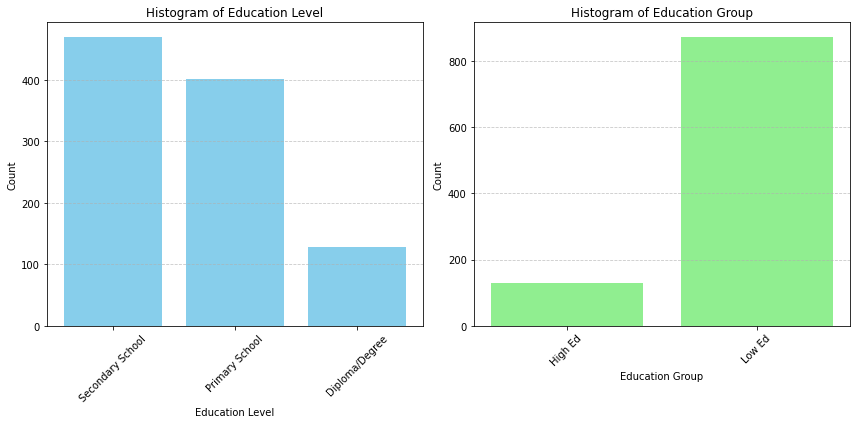

In [5]:
import matplotlib.pyplot as plt

# Collect the counts of each education level in df_grouped
education_group_counts = df_grouped.groupBy("Education_Group").count().collect()
# Collect the counts of each education level in df_grouped
education_level_counts = df_grouped.groupBy("Education_Level").count().collect()

# Extract education groups and their corresponding counts
education_group_levels = [row["Education_Group"] for row in education_group_counts]
education_group_counts = [row["count"] for row in education_group_counts]

# Extract education groups and their corresponding counts
education_levels = [row["Education_Level"] for row in education_level_counts]
education_counts = [row["count"] for row in education_level_counts]

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for Education_Level
axs[0].bar(education_levels, education_counts, color='skyblue')
axs[0].set_xlabel('Education Level')
axs[0].set_ylabel('Count')
axs[0].set_title('Histogram of Education Level')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for Education_Group
axs[1].bar(education_group_levels, education_group_counts, color='lightgreen')
axs[1].set_xlabel('Education Group')
axs[1].set_ylabel('Count')
axs[1].set_title('Histogram of Education Group')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [6]:
# Calculate the total number of individuals
total_individuals = df_grouped.count()

# Collect the counts of each education level in df_grouped
education_level_counts = df_grouped.groupBy("Education_Level").count().collect()

# Calculate and display the percentages for each education level
print("Education Level\t| Percentage")
print("-" * 30)
for row in education_level_counts:
    education_level = row["Education_Level"]
    count = row["count"]
    percentage = (count / total_individuals) * 100
    print(f"{education_level}| {percentage:.2f}%")


Education Level	| Percentage
------------------------------
Secondary School| 47.00%
Primary School| 40.20%
Diploma/Degree| 12.80%


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Boosting Dataset") \
    .getOrCreate()


# Desired percentages for each education level
desired_percentages = {
    "Primary School": 0.50,
    "Secondary School": 0.48,
    "Diploma/Degree": 0.45
}

# Total number of rows desired in the boosted dataset
total_rows_desired = 1500  # For example, if you want more than 1000 rows

# Calculate the desired counts for each education level
desired_counts = {level: int(total_rows_desired * percentage) for level, percentage in desired_percentages.items()}

# Create an empty DataFrame with the same schema as df_grouped
boosted_df = spark.createDataFrame([], df_grouped.schema)

# Create new rows for each education level and union with the original DataFrame
for level, count in desired_counts.items():
    # Filter the original DataFrame for the current education level
    level_df = df_grouped.filter(df_grouped["Education_Level"] == level)
    
    # Duplicate rows to achieve the desired count
    duplicated_rows = level_df.limit(count - level_df.count())
    
    # Union the original DataFrame with the duplicated rows
    boosted_df = boosted_df.union(level_df.union(duplicated_rows))

# Show the boosted DataFrame
# Count the total number of rows in the DataFrame
total_count = boosted_df.count()

# Display the total count
print("Total count of rows:", total_count)



Total count of rows: 1726


In [8]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = boosted_df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = boosted_df.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = boosted_df.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = boosted_df.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(boosted_df)


DataFrame Summary:
Total Rows     : 1726
Total Columns  : 20

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  1726            0          double    
AlcoholLevel              1726            0          double    
HeartRate                 1726            0          double    
BodyTemperature           1726            0          double    
Weight                    1726            0          double    
MRI_Delay                 1726            0          double    
Age                       1726            0          double    
Education_Level           1726            0          string    
Gender                    1726            0          string    
Family_History            1726            0          string    
Smoking_Status            1726            0          string    
APOE_ε4                   1726            0          string    
Physical_Activity         1

In [9]:
# Show a sample of the boosted DataFrame
boosted_df.show()

# Count the total number of rows in the boosted DataFrame
total_rows = boosted_df.count()
print("Total number of rows in boosted DataFrame:", total_rows)

+--------+------------+---------+------------------+------------+-----------+----+---------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|Diabetic|AlcoholLevel|HeartRate|   BodyTemperature|      Weight|  MRI_Delay| Age|Education_Level|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|Dementia|Education_Group|
+--------+------------+---------+------------------+------------+-----------+----+---------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|     1.0| 0.084973629|     98.0|       36.22485168| 57.56397754|36.42102798|60.0| Primary School|Female|            No|Current Smoker|Nega

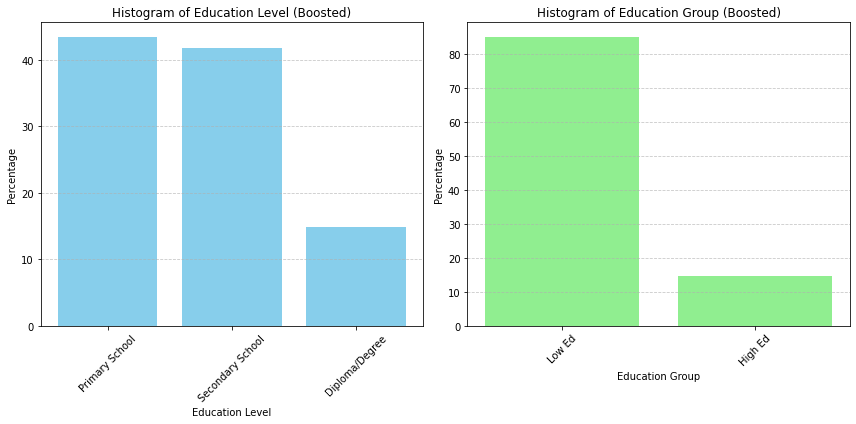

In [10]:
import matplotlib.pyplot as plt

# Collect the counts of each education level in boosted_df
boosted_education_group_counts = boosted_df.groupBy("Education_Group").count().collect()
boosted_education_level_counts = boosted_df.groupBy("Education_Level").count().collect()

# Extract education groups and their corresponding counts
boosted_education_group_levels = [row["Education_Group"] for row in boosted_education_group_counts]
boosted_education_group_counts = [row["count"] for row in boosted_education_group_counts]

# Extract education levels and their corresponding counts
boosted_education_levels = [row["Education_Level"] for row in boosted_education_level_counts]
boosted_education_counts = [row["count"] for row in boosted_education_level_counts]

# Calculate total count for boosted_df
total_boosted_count = boosted_df.count()

# Convert counts to percentages
boosted_education_group_percentages = [count / total_boosted_count * 100 for count in boosted_education_group_counts]
boosted_education_percentages = [count / total_boosted_count * 100 for count in boosted_education_counts]

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for Education_Level
axs[0].bar(boosted_education_levels, boosted_education_percentages, color='skyblue')
axs[0].set_xlabel('Education Level')
axs[0].set_ylabel('Percentage')
axs[0].set_title('Histogram of Education Level (Boosted)')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for Education_Group
axs[1].bar(boosted_education_group_levels, boosted_education_group_percentages, color='lightgreen')
axs[1].set_xlabel('Education Group')
axs[1].set_ylabel('Percentage')
axs[1].set_title('Histogram of Education Group (Boosted)')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [11]:
# Calculate the total number of individuals in the boosted_df DataFrame
total_individuals_boosted = boosted_df.count()

# Collect the counts of each education level in boosted_df
education_level_counts_boosted = boosted_df.groupBy("Education_Level").count().collect()

# Calculate and display the percentages for each education level in boosted_df
print("Education Level\t| Percentage")
print("-" * 30)
for row in education_level_counts_boosted:
    education_level = row["Education_Level"]
    count = row["count"]
    percentage = (count / total_individuals_boosted) * 100
    print(f"{education_level}\t| {percentage:.2f}%")


Education Level	| Percentage
------------------------------
Primary School	| 43.45%
Secondary School	| 41.71%
Diploma/Degree	| 14.83%


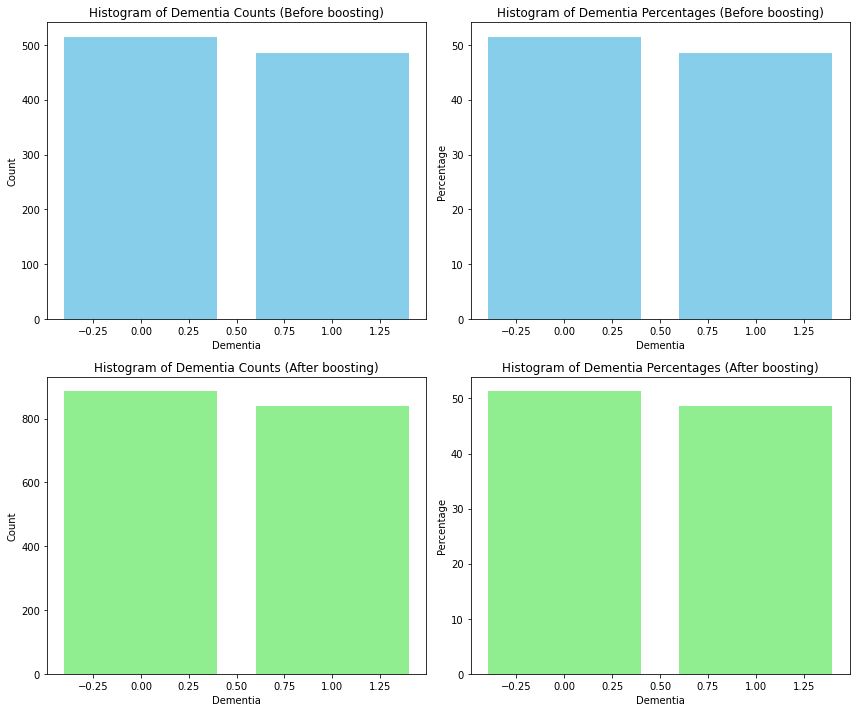

In [12]:
import matplotlib.pyplot as plt

# Calculate percentages of dementia for df_grouped
dementia_counts_grouped = df_grouped.groupBy("Dementia").count().collect()
total_individuals_grouped = df_grouped.count()
dementia_percentage_grouped = [(row["Dementia"], (row["count"] / total_individuals_grouped) * 100) for row in dementia_counts_grouped]

# Calculate percentages of dementia for boosted_df
dementia_counts_boosted = boosted_df.groupBy("Dementia").count().collect()
total_individuals_boosted = boosted_df.count()
dementia_percentage_boosted = [(row["Dementia"], (row["count"] / total_individuals_boosted) * 100) for row in dementia_counts_boosted]

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for counts of dementia in df_grouped
axs[0, 0].bar([x[0] for x in dementia_counts_grouped], [x[1] for x in dementia_counts_grouped], color='skyblue')
axs[0, 0].set_xlabel('Dementia')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_title('Histogram of Dementia Counts (Before boosting)')

# Histogram for percentages of dementia in df_grouped
axs[0, 1].bar([x[0] for x in dementia_percentage_grouped], [x[1] for x in dementia_percentage_grouped], color='skyblue')
axs[0, 1].set_xlabel('Dementia')
axs[0, 1].set_ylabel('Percentage')
axs[0, 1].set_title('Histogram of Dementia Percentages (Before boosting)')

# Histogram for counts of dementia in boosted_df
axs[1, 0].bar([x[0] for x in dementia_counts_boosted], [x[1] for x in dementia_counts_boosted], color='lightgreen')
axs[1, 0].set_xlabel('Dementia')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_title('Histogram of Dementia Counts (After boosting)')

# Histogram for percentages of dementia in boosted_df
axs[1, 1].bar([x[0] for x in dementia_percentage_boosted], [x[1] for x in dementia_percentage_boosted], color='lightgreen')
axs[1, 1].set_xlabel('Dementia')
axs[1, 1].set_ylabel('Percentage')
axs[1, 1].set_title('Histogram of Dementia Percentages (After boosting)')

plt.tight_layout()
plt.show()


In [13]:
from pyspark.sql.functions import col, round

# Iterate over the columns of the DataFrame
for col_name in boosted_df.columns:
    # Check if the column is numerical
    if str(boosted_df.schema[col_name].dataType) in ["DoubleType", "FloatType", "DecimalType", "IntegerType", "LongType"]:
        # Round up the numerical values in the column
        boosted_df = boosted_df.withColumn(col_name, round(col(col_name), 2))

# Show the first few rows of the DataFrame with rounded numerical values
boosted_df.show()


+--------+------------+---------+---------------+------+---------+----+---------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|Diabetic|AlcoholLevel|HeartRate|BodyTemperature|Weight|MRI_Delay| Age|Education_Level|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|Dementia|Education_Group|
+--------+------------+---------+---------------+------+---------+----+---------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|     1.0|        0.08|     98.0|          36.22| 57.56|    36.42|60.0| Primary School|Female|            No|Current Smoker|Negative|        Sedentary|               No|   

# 3.4 Integrate various data sources

In [14]:
# Save DataFrame to a CSV file
#boosted_df.write.csv("Dataset/df_new_3_100%.csv", header=True)

In [15]:
# Define the fraction for sampling (30%)
fraction = 0.3

# Sample 30% of the data randomly from boosted_df
random_data_df = boosted_df.sample(fraction=fraction, seed=42)

# Show the sampled DataFrame
# Count the total number of rows in the DataFrame
total_count = random_data_df.count()

# Display the total count
print("Total count of rows:", total_count)


Total count of rows: 545


In [16]:
# Save DataFrame to a CSV file
#random_data_df.write.csv("Dataset/df_new_3_30%.csv", header=True)

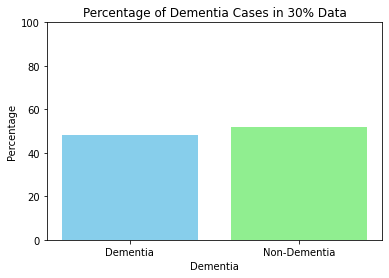

Dementia Percentage: 48.07339449541285 %
Non-Dementia Percentage: 51.92660550458715 %


In [17]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col


# Calculate the counts of dementia and non-dementia cases
dementia_counts = random_data_df.filter(random_data_df["Dementia"] == 1).count()
non_dementia_counts = random_data_df.filter(random_data_df["Dementia"] == 0).count()

# Calculate the total number of individuals
total_individuals = random_data_df.count()

# Calculate the percentages of dementia cases
dementia_percentage = (dementia_counts / total_individuals) * 100
non_dementia_percentage = (non_dementia_counts / total_individuals) * 100

# Plot the histogram
labels = ['Dementia', 'Non-Dementia']
percentages = [dementia_percentage, non_dementia_percentage]

plt.bar(labels, percentages, color=['skyblue', 'lightgreen'])
plt.xlabel('Dementia')
plt.ylabel('Percentage')
plt.title('Percentage of Dementia Cases in 30% Data')
plt.ylim(0, 100)
plt.show()



# Display the percentages
print("Dementia Percentage:", dementia_percentage, "%")
print("Non-Dementia Percentage:", non_dementia_percentage, "%")


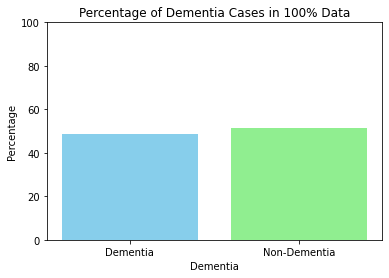

Dementia Percentage: 48.66743916570104 %
Non-Dementia Percentage: 51.33256083429896 %


In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col


# Calculate the counts of dementia and non-dementia cases
dementia_counts = boosted_df.filter(boosted_df["Dementia"] == 1).count()
non_dementia_counts = boosted_df.filter(boosted_df["Dementia"] == 0).count()

# Calculate the total number of individuals
total_individuals = boosted_df.count()

# Calculate the percentages of dementia cases
dementia_percentage = (dementia_counts / total_individuals) * 100
non_dementia_percentage = (non_dementia_counts / total_individuals) * 100

# Plot the histogram
labels = ['Dementia', 'Non-Dementia']
percentages = [dementia_percentage, non_dementia_percentage]

plt.bar(labels, percentages, color=['skyblue', 'lightgreen'])
plt.xlabel('Dementia')
plt.ylabel('Percentage')
plt.title('Percentage of Dementia Cases in 100% Data')
plt.ylim(0, 100)
plt.show()



# Display the percentages
print("Dementia Percentage:", dementia_percentage, "%")
print("Non-Dementia Percentage:", non_dementia_percentage, "%")


In [19]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Merge Datasets") \
    .getOrCreate()

# Read the CSV files into DataFrames
df_merge1 = spark.read.csv('Dataset/df_new_3_100%.csv', header=True, inferSchema=True)
df_merge2 = spark.read.csv('Dataset/df_new_3_30%.csv', header=True, inferSchema=True)

# Merge the DataFrames using union
df_merged = df_merge1.union(df_merge2)

# Show the merged DataFrame
df_merged.show()



+--------+------------+---------+---------------+------+---------+----+----------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|Diabetic|AlcoholLevel|HeartRate|BodyTemperature|Weight|MRI_Delay| Age| Education_Level|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|Dementia|Education_Group|
+--------+------------+---------+---------------+------+---------+----+----------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+-------------+-------------------------+--------+---------------+
|     1.0|        0.11|    123.0|          36.68| 66.59|    21.15|67.0|Secondary School|  Male|            No| Former Smoker|Positive|    Mild Activity|              Yes

In [20]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df_merged.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df_merged.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df_merged.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_merged)


DataFrame Summary:
Total Rows     : 2271
Total Columns  : 20

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  2271            0          double    
AlcoholLevel              2271            0          double    
HeartRate                 2271            0          double    
BodyTemperature           2271            0          double    
Weight                    2271            0          double    
MRI_Delay                 2271            0          double    
Age                       2271            0          double    
Education_Level           2271            0          string    
Gender                    2271            0          string    
Family_History            2271            0          string    
Smoking_Status            2271            0          string    
APOE_ε4                   2271            0          string    
Physical_Activity         2

In [21]:
def count_outliers_iqr(df_merged):
    # Define an empty dictionary to store the results
    results = {}
    
    # Loop through each numerical column in the DataFrame
    for column in df_merged.columns:
        if df_merged.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            # Calculate quartiles for the column
            quartiles = df_merged.approxQuantile(column, [0.25, 0.75], 0.01)
            q1 = quartiles[0]
            q3 = quartiles[1]
            
            # Calculate IQR for the column
            iqr = q3 - q1
            
            # Calculate lower and upper bounds for outliers
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            # Count the number of values less than the lower bound or greater than the upper bound
            count_outliers = df_merged.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
            
            # Count the number of values less than the lower bound or greater than the upper bound by 3*IQR
            count_extremes = df_merged.filter((col(column) < (q1 - 3 * iqr)) | (col(column) > (q3 + 3 * iqr))).count()
            
            # Add the counts to the dictionary
            results[column] = (count_outliers, count_extremes)
    
    # Return the dictionary containing counts of outliers and extreme values for each column
    return results




In [22]:
# Count outliers and extreme values for each column using IQR method for df_new_2
outlier_counts_iqr_2 = count_outliers_iqr(df_merged)

# Display the header of the table
print("Column Name            | Outliers   | Extreme Values")
print("-------------------------------------------------")

# Display the counts of outliers and extreme values for each column using IQR method for df_new_2
for column, (outliers, extremes) in outlier_counts_iqr_2.items():
    print(f"{column: <22} | {outliers: <10} | {extremes: <13}")

Column Name            | Outliers   | Extreme Values
-------------------------------------------------
Diabetic               | 0          | 0            
AlcoholLevel           | 0          | 0            
HeartRate              | 0          | 0            
BodyTemperature        | 0          | 0            
Weight                 | 0          | 0            
MRI_Delay              | 0          | 0            
Age                    | 0          | 0            
Cognitive_Test_Scores  | 0          | 0            
Dementia               | 0          | 0            


# 3.5 Formatting Data

In [23]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df_merge1.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df_merge1.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df_merge1.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_merge1)


DataFrame Summary:
Total Rows     : 1726
Total Columns  : 20

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  1726            0          double    
AlcoholLevel              1726            0          double    
HeartRate                 1726            0          double    
BodyTemperature           1726            0          double    
Weight                    1726            0          double    
MRI_Delay                 1726            0          double    
Age                       1726            0          double    
Education_Level           1726            0          string    
Gender                    1726            0          string    
Family_History            1726            0          string    
Smoking_Status            1726            0          string    
APOE_ε4                   1726            0          string    
Physical_Activity         1

In [24]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df_merge2.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df_merge2.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df_merge2.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_merge2)


DataFrame Summary:
Total Rows     : 545
Total Columns  : 20

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
Diabetic                  545             0          double    
AlcoholLevel              545             0          double    
HeartRate                 545             0          double    
BodyTemperature           545             0          double    
Weight                    545             0          double    
MRI_Delay                 545             0          double    
Age                       545             0          double    
Education_Level           545             0          string    
Gender                    545             0          string    
Family_History            545             0          string    
Smoking_Status            545             0          string    
APOE_ε4                   545             0          string    
Physical_Activity         54

In [25]:
# Save DataFrame to a CSV file
#df_merged.write.csv("Dataset/df_new_4.csv", header=True)

In [26]:
# Finish